# Combine data from Google Earth Engine (GEE) and Geoscience Australia (GA) <img align="right" src="../Supplementary_data/dea_logo.jpg">
## Sentinel-1 example
* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[wofs_annual_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_annual_summary)
[Sentinel-1 SAR GRD](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)

## Background
GEE is a geospatial processing service. It has the option to be run through it's online JavaScript Code Editor, or can be accessed in python platforms such as Colab and Jupyter Notebooks. GEE provides access to many different datasets, climate data, PALSAR and MODIS (https://developers.google.com/earth-engine/datasets/catalog) which can be combined with data from DEA. 

To get started with GEE these links may help:
- User guides: https://developers.google.com/earth-engine/guides
- Get started using GEE with python: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

>**Note**: You will need a Google Earth Engine account subject to their terms and conditions (https://earthengine.google.com/terms/). [Sign up here.](https://signup.earthengine.google.com/)

## Description
This notebook demonstrates how to access Sentinel-1 data stored in GEE and determine where water (basic water proxy for demonstration only) is present in the landscape.

1. Install GEE API
2. Load python packages
3. Connect to datacube
4. Connect to GEE API
5. Load GEE imagery
6. Convert GEE image to numpy array
7. Load GA image

***


### Install GEE API

In [20]:
!pip install earthengine-api

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


### Load packages
Import Python packages that are used for the analysis.

In [21]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import sys
import folium
import datacube

sys.path.append("../Scripts")
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [22]:
dc = datacube.Datacube(app='gee')

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [23]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Load Imagery

### Define parameters 

In [24]:
# Define parameters

# Dates
# NOTE: GEE dates are inclusive and GA are exclusive on the end date
start = '2018-01-01'
end_ga = '2018-12-31'
end_gee = '2019-01-01'

# Set the central latitude and longitude
central_lat = -35.294476
central_lon = 149.111817

In [25]:
# Set the buffer to load around the central coordinates
buffer = 0.05 # must be small for .sampleRectangle() to work

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

### Load GEE imagery

To load imagery from GEE generally you will need to:
- define an area of interest and pass to `filterBounds`
- define a time period of interest and pass to `filterDate`
- select bands of interest
- reproject

Imagery without a set projection will be called in WGS 94. Sentinel-1 pixels in GEE are 10m in length.

>**Note**: All options for how to manipulate GEE objects can be found here https://developers.google.com/earth-engine/apidocs

In [26]:
# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[study_area_lon[0], study_area_lat[0]],
    [study_area_lon[0], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[1]],
    [study_area_lon[1], study_area_lat[0]]]], None, False)

# Filter image collection
img_VV_VH = (ee.ImageCollection('COPERNICUS/S1_GRD')
         .filterBounds(aoi)
         .filterDate(start,end_gee)
         .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
         .filter(ee.Filter.eq('instrumentMode', 'IW'))
         .select('VV','VH'))

# Create a descending mean image
desc = (img_VV_VH.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
        .mean())

In [27]:
print(desc.getInfo())

{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


### Smooth the sentinel imagery
We have already smoothed temporally, but we will also smooth spatially. A `focal_mean` is a simple way to achieve spatial smoothing.

In [28]:
# Smooth imagery and reproject for comparison with WOfS
desc = (desc.focal_mean(2,'square','pixels')
            .reproject('EPSG:3577',None,25))

### Display GEE imagery on a folium map

In [29]:
# Map location in lats and lons
location=[central_lat, central_lon]

# How zoomed in the map is
zoom_start=12

# Set visualization parameters.
vis_params_vh = {
  'bands':['VH'], # check which abnds here https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands
  'min': -25, # pixel value
  'max': 5 # pixel value
}

# Set visualization parameters.
vis_params_vv = {
  'bands':['VV'], # check which abnds here https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands
  'min': -25, # pixel value
  'max': 5 # pixel value
}


In [30]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
my_map = folium.Map(location=location, zoom_start=zoom_start, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(desc, vis_params_vv, 'VV mean')
my_map.add_ee_layer(desc, vis_params_vh, 'VH mean')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Convert GEE image into a numpy array

The image returned to us is an ee.Image object. To integrate this with GA imagery, we need to convert the image object into an xarray.

In [31]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = desc.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_vv = band_arrs.get('VV')
band_arr_vh = band_arrs.get('VH')

# Transfer the arrays from server to client and cast as np array.
np_arr_vv = np.array(band_arr_vv.getInfo())
np_arr_vh = np.array(band_arr_vh.getInfo())

# Print np_arr_vv to check
np_arr_vv

array([[ -8.17993624,  -8.09810977,  -8.32406336, ...,  -8.94029872,
         -8.79841064,  -8.71372661],
       [ -8.56012764,  -8.3265096 ,  -8.41476743, ...,  -9.22510119,
         -8.80818164,  -8.64615388],
       [ -9.09762002,  -8.66672289,  -8.47694414, ...,  -9.58073663,
         -8.92451141,  -8.68724723],
       ...,
       [ -9.0552432 ,  -8.64589681,  -8.7726917 , ..., -16.1795608 ,
        -16.52191048, -16.66358195],
       [ -9.3732077 ,  -9.14393907,  -9.30630861, ..., -16.35091341,
        -16.66470253, -16.84776752],
       [ -9.45056971,  -9.20445057,  -9.31362483, ..., -16.34371691,
        -16.63140374, -16.93585538]])

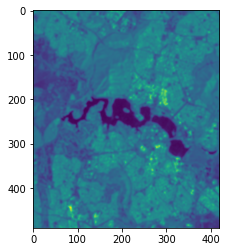

In [32]:
# Plot array
plt.imshow(np_arr_vh)
plt.show()

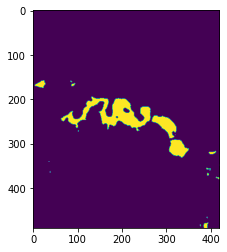

In [33]:
# Calculate where water is
### NOTE: Demo thresholds only ###
vh_water = np_arr_vh < -25
vv_water = np_arr_vv < -17
s1_water = vh_water & vv_water 

# Plot array
plt.imshow(s1_water)
plt.show()

### Load GA data

In [34]:
# Load wofs_annual_summary
wofs = dc.load(
              product=['wofs_annual_summary'],
              x= study_area_lon,
              y= study_area_lat,
              time=(start, end_ga),
              output_crs='EPSG:3577',
              resolution=(-25,25),
              resampling='cubic'
)

In [35]:
wofs_water = wofs['count_wet'] > 2 
wofs_water = np.array(wofs_water[0,:,:])

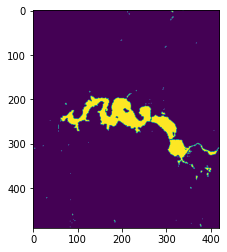

In [36]:
# Display wofs data
plt.imshow(wofs_water)
plt.show()

### The imagery should now be comparable

Text(0.5, 1.0, 'S1 water (from GEE)')

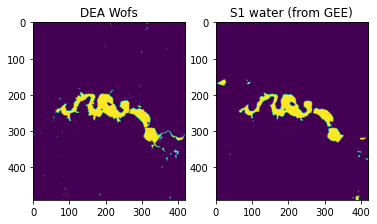

In [37]:
# Display imagery side-by-side
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.array(wofs_water))
ax1.set_title('DEA Wofs')
ax2.imshow(s1_water)
ax2.set_title('S1 water (from GEE)')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [38]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)